## Overview

This project trains an LSTM recurrent neural network to classify movie genres based on IMDB descriptions. It then recreates the network interpretation visualizations from Garcia *et. al* 2021: Visual analytics tool for the interpretation of hidden states in recurrent neural networks. (https://vciba.springeropen.com/articles/10.1186/s42492-021-00090-0)

## Contents

 1. [Introduction](#introduction)
 2. [Preprocessing](#preprocessing)
 3. [Model](#model)
 4. [Training](#training)
 5. [Visualization](#visualization)

In [1]:
import pandas as pd
import numpy as np
import torch.optim as optim

from models import *

## 1. Introduction<a name="introduction"></a>

The main advantage of Recurrent Neural Networks (RNNs) is that they can process input sequences of arbitrary length, as opposed to traditional neural networks that only process inputs as single vectors of fixed length. This makes them useful for working with time series and text, among other sequential data types. 

However, this feature of RNNs poses some difficulties for interpreting their reasoning. For traditional neural networks, interpreters can look at single passes through the network, but for RNNs, we need to look at how the network evolves across entire input sequences. Garcia *et. al* demonstrate some interesting RNN visualization techniques using the example of a simple Long Short-Term Memory (LSTM) recurrent network trained to predict whether an IMDB movie review was positive or negative.

In this project, I extend these techniques to a multi-class problem: predicting a movie's genre from its IMDB description (https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb/data). I use PyTorch to build, train, and evaluate an LSTM network for this task. I then recreate the visualizations from Garcia *et. al* in a multi-class setting to learn more about how this network reasons.

## 2. Preprocessing<a name="preprocessing"></a>

This package contains a module, imdb_data_prep.py, that performs the initial preprocessing. It gathers the "raw" train and test data into dataframes before cleaning the description text and lemmatizing the result using Spacy. It then builds a PyTorch vocabulary from the lemmatized training set descriptions, and uses the vocabulary to tokenize the descriptions so that they can be input to a PyTorch embedding layer.

For both the train and test sets, I load the movie info dataframe and the tokenized representations. I also load the vocabulary.

A few notes here:
 - For now, I limit the dataset to the 3 most common genres: drama, documentary, and comedy.
 - I limit the descriptions to at most the first 100 words (most contain fewer than that).
 - When constructing the vocabulary, I set the minimum word frequency at 60. A word must appear at least 60 times in the dataset to get a unique token in the vocabulary; otherwise, it is mapped to the unknown ("\<unk>") token.
    - Not every member of the vocabulary is actually a "word"; my preprocessing leaves most punctuation in and separates some non-words like possessive morphemes ('s).
 - For the purposes of constructing the vocabulary and tokenized representations, the relevant column is **lemmatized_description_list_trunc**, which contains the movie descriptions after cleaning, lemmatizing, and truncating to at most 100 words.

In [2]:
genres3 = ['drama', 'documentary', 'comedy']
max_length=100
min_freq=60

In [3]:
df3 = pd.read_pickle('data/imdb_train_processed_3_genres.pkl')
df3_test = pd.read_pickle('data/imdb_test_processed_3_genres.pkl')
df3.head()

,title_year,genre,description,title,year,clean_description,clean_description_list,lemmatized_description_list,clean_description_list_trunc,lemmatized_description_list_trunc
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Oscar et la dame rose,2009,Listening in to a conversation between his doc...,"[Listening, in, to, a, conversation, between, ...","[listen, in, to, a, conversation, between, his...","[Listening, in, to, a, conversation, between, ...","[listen, in, to, a, conversation, between, his..."
1,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,The Secret Sin,1915,To help their unemployed father make ends meet...,"[To, help, their, unemployed, father, make, en...","[to, help, their, unemployed, father, make, en...","[To, help, their, unemployed, father, make, en...","[to, help, their, unemployed, father, make, en..."
2,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The Unrecovered,2007,The film's title refers not only to the un-rec...,"[The, film, 's, title, refers, not, only, to, ...","[the, film, 's, title, refer, not, only, to, t...","[The, film, 's, title, refers, not, only, to, ...","[the, film, 's, title, refer, not, only, to, t..."
3,Quality Control (2011),documentary,Quality Control consists of a series of 16mm s...,Quality Control,2011,Quality Control consists of a series of 16mm s...,"[Quality, Control, consists, of, a, series, of...","[Quality, Control, consist, of, a, series, of,...","[Quality, Control, consists, of, a, series, of...","[Quality, Control, consist, of, a, series, of,..."
4,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all ...,Pink Slip,2009,In tough economic times Max and Joey have all ...,"[In, tough, economic, times, Max, and, Joey, h...","[in, tough, economic, time, Max, and, Joey, ha...","[In, tough, economic, times, Max, and, Joey, h...","[in, tough, economic, time, Max, and, Joey, ha..."


In [4]:
X_train3 = torch.load('data/X_train{}.pt'.format(len(genres3)))
y_train3 = torch.load('data/y_train{}.pt'.format(len(genres3)))
X_test3 = torch.load('data/X_test{}.pt'.format(len(genres3)))
y_test3 = torch.load('data/y_test{}.pt'.format(len(genres3)))
vocab3 = torch.load('saved_models/vocab{}.pt'.format(len(genres3)))
print('Training points:', len(X_train3))
print('Testing points:', len(X_test3))

Training points: 34156
Testing points: 34154


In [5]:
print(df3['genre'].value_counts())

genre
drama          13613
documentary    13096
comedy          7447
Name: count, dtype: int64


The training dataset contains 34,156 movies: 13,613 dramas, 13,096 documentaries, and 7447 comedies.

In [6]:
print('Vocab size:', len(vocab3))
# min_freq - 40: 4821.  50: 4068.  60: 3525.  80: 2832.  100: 2391.
# unknown %: 40: 0.105. 50: 0.118. 60: 0.129. 80: 0.145. 100: 0.159.

Vocab size: 3525


In [7]:
X_train3.explode().apply(lambda x: x.item()).value_counts(normalize=True).head(5)

lemmatized_description_list_trunc
0    0.128647
1    0.051361
2    0.049624
3    0.036961
4    0.029225
Name: proportion, dtype: float64

The vocab contains 3525 unique tokens (including unknown, which accounts for 12.9% of the training data). The 20 most- and least-common words in the vocabulary are displayed below.

In [8]:
print(vocab3.get_itos()[:20])
print(vocab3.get_itos()[-20:])

['<unk>', 'the', ',', '.', 'and', 'a', 'of', 'be', 'to', 'in', 'his', '-', 'he', 'with', "'s", 'have', 'for', 'that', 'on', 'her']
['bombing', 'capable', 'cow', 'downtown', 'guidance', 'hook', 'infant', 'insane', 'miserable', 'negative', 'peculiar', 'print', 'revive', 'screenwriter', 'semi', 'sharp', 'stretch', 'surrounding', 'unveil', 'y']


## 3. Model<a name="model"></a>

The code for the model can be found in another module in this package, models.py. The model is a recurrent network that sequentially takes each input through an embedding layer, single LSTM layer, dropout layer, and linear layer with softmax activation. I set the embedding size to 64 and the hidden size to 128. The output size is of course 3, with probability assigned to each genre.

In [9]:
vocab_size = len(vocab3)
embedding_size = 64
hidden_size = 128
output_size = len(genres3)

In [10]:
torch.manual_seed(0)

In [11]:
lstm3 = LSTM(vocab_size, embedding_size, hidden_size, output_size)
lstm3

LSTM(
  (embedding): Embedding(3525, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (h_2_o): Linear(in_features=128, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
  (softmax): Softmax(dim=1)
)

Training will attempt to minimize the negative log likelihood loss. The class memberships are imbalanced, with a little over half as many comedies as each of the other genres. To deal with this issue, the loss function gives each class a weight that's inversely proportional to its size. 

In [12]:
n_tot3 = len(X_train3)
genre_weights3 = []
for genre in genres3:
    p = len(df3[df3['genre']==genre])/n_tot3
    genre_weights3.append(1/p)
genre_weights3 = nn.functional.normalize(torch.tensor(genre_weights3), p=1, dim=0)
genre_weights3

tensor([0.2586, 0.2688, 0.4727])

In [13]:
loss_criterion3=nn.NLLLoss(weight=genre_weights3, reduction='none')

## 4. Training<a name="training"></a>

I train the model for 15 epochs, keeping track of both training and test set accuracy after each epoch.

In [14]:
optimizer3 = optim.Adam(lstm3.parameters(), lr=0.001)

In [15]:
lstm3.fit(X_train3, y_train3, optimizer3, loss_criterion3, 
          epochs=15, track_train_stats=True, track_test_stats=True, # !!! epochs=20
          X_test=X_test3, y_test=y_test3,
          verbose=True) 

Epoch 1
Train Accuracy: 0.7448
Test Accuracy: 0.7256
Epoch 2
Train Accuracy: 0.7933
Test Accuracy: 0.7464
Epoch 3
Train Accuracy: 0.8282
Test Accuracy: 0.7614
Epoch 4
Train Accuracy: 0.848
Test Accuracy: 0.7537
Epoch 5
Train Accuracy: 0.8779
Test Accuracy: 0.7624
Epoch 6
Train Accuracy: 0.8952
Test Accuracy: 0.7585
Epoch 7
Train Accuracy: 0.9088
Test Accuracy: 0.7619
Epoch 8
Train Accuracy: 0.8824
Test Accuracy: 0.7355
Epoch 9
Train Accuracy: 0.9206
Test Accuracy: 0.7489
Epoch 10
Train Accuracy: 0.934
Test Accuracy: 0.7525
Epoch 11
Train Accuracy: 0.9393
Test Accuracy: 0.7565
Epoch 12
Train Accuracy: 0.9395
Test Accuracy: 0.7512
Epoch 13
Train Accuracy: 0.9465
Test Accuracy: 0.7528
Epoch 14
Train Accuracy: 0.9459
Test Accuracy: 0.7563
Epoch 15
Train Accuracy: 0.9441
Test Accuracy: 0.7555


Though training set accuracy generally increases throughout training, test set accuracy peaks in epoch 5 before plateauing. I'll train a new model (with the same random seeds, so the same results) for 5 epochs and use this one in the visualizations. 

In [16]:
torch.save(lstm3.state_dict(), 'saved_models/imdb_wordspos_100_60_lstm3_temp.pt') # max_length: 100. min_freq: 60.

In [17]:
torch.manual_seed(0)

In [18]:
lstm3 = LSTM(vocab_size, embedding_size, hidden_size, output_size)

In [19]:
optimizer3 = optim.Adam(lstm3.parameters(), lr=0.001)

In [20]:
lstm3.fit(X_train3, y_train3, optimizer3, loss_criterion3, 
          epochs=5, track_train_stats=True, track_test_stats=True,
          X_test=X_test3, y_test=y_test3,
          verbose=True)

Epoch 1
Train Accuracy: 0.7448
Test Accuracy: 0.7256
Epoch 2
Train Accuracy: 0.7933
Test Accuracy: 0.7464
Epoch 3
Train Accuracy: 0.8282
Test Accuracy: 0.7614
Epoch 4
Train Accuracy: 0.848
Test Accuracy: 0.7537
Epoch 5
Train Accuracy: 0.8779
Test Accuracy: 0.7624


In [21]:
torch.save(lstm3.state_dict(), 'saved_models/imdb_words_100_60_lstm3.pt') # max_length: 100. min_freq: 60.

## 5. Visualization<a name="visualization"></a>

Garcia *et. al* created a dashboard for visualizing a recurrent network's operation across a sequence (shown below). In this section, I discuss and recreate the important components of this dashboard (marked B, C, D, and E) for the multi-class genre classification problem.

![title](img/lstm_visualization.png)

In [22]:
lstm3 = LSTM(vocab_size, embedding_size, hidden_size, output_size)
lstm3.load_state_dict(torch.load('saved_models/imdb_words_100_60_lstm3.pt'))

<All keys matched successfully>

For this notebook, I stored the model hidden states, outputs, predictions, and other information in a local database. This allows me to easily access information about individual movies using SQL queries without having to load massive amounts of information into memory. For the app, I created a database in Google Cloud.

In [23]:
from sklearn.decomposition import IncrementalPCA
import seaborn as sns
import matplotlib.pyplot as plt
import html
from IPython.display import display, HTML
import pickle
import sqlite3

### 5.1 Sequence Color-Coding

Component (B) displays the description text with each word (or other unit) color-coded using the model's output at that step of the sequence. The hue is determined by the predicted class, and the tint increases (becomes more white) as the model's confidence in that prediction decreases.

I define a map assigning each class a hue represented by an rgb triple.

In [24]:
# https://www.learnui.design/tools/data-color-picker.html#palette . For hex colors.
# https://www.rgbtohex.net/hex-to-rgb/ . Hex to RGB
color_map = {0: 'rgb(0,63,92,', 1: 'rgb(188,80,144,', 2: 'rgb(255,166,0,'}
color_float_map = {0: [0/255,63/255,92/255], 1: [188/255,80/255,144/255], 2: [255/255,166/255,0/255]}

Here are the colors I use for each class:

In [25]:
def html_escape(text): # https://adataanalyst.com/machine-learning/highlight-text-using-weights/
    return html.escape(text)
    
for i, genre in enumerate(genres3):
    highlighted_text = '<span style="background-color:' + color_map[i] + str(0.75) + ');">' + html_escape(genre) + '</span>'
    display(HTML(highlighted_text))

In [26]:
def display_description_with_classes(movie_index, max_alpha=0.75):

    conn = sqlite3.connect('data/imdb_app.db')
    cursor = conn.cursor()

    res_desc = cursor.execute('''
        SELECT * FROM Descriptions
        WHERE movie_id = {i}
        '''.format(i=movie_index)
        )
    movie_desc = res_desc.fetchone()
    text = movie_desc[1].split(' ')
    actual_genre = movie_desc[2]
    predicted_genre = movie_desc[3]
    confidence = movie_desc[4]

    caption = ['Actual: ']
    caption.append('<span style="background-color:' + color_map[genres3.index(actual_genre)
                   ] + str(max_alpha) + ');">' + html_escape(actual_genre) + '</span>')
    caption.append('. Predicted: ')
    caption.append('<span style="background-color:' + color_map[genres3.index(predicted_genre)
                   ] + str(confidence*max_alpha) + ');">' + html_escape(predicted_genre) + '</span>')
    
    caption = ' '.join(caption)
    display(HTML(caption))

    res_ho = cursor.execute('''
        SELECT * FROM Hiddens_Outputs
        WHERE movie_id = {i}
        '''.format(i=movie_index)
        )
    movie_ho = res_ho.fetchall()

    predictions = [layer[4] for layer in movie_ho]
    confidences = [layer[5] for layer in movie_ho]
    
    highlighted_text = []
    for i, word in enumerate(text):
        confidence = confidences[i]
        pred = predictions[i]
        
        if confidence is not None:
            highlighted_text.append('<span style="background-color:' + color_map[pred
                ] + str(confidence*max_alpha) + ');">' + html_escape(word) + '</span>')
        else:
            highlighted_text.append(word)
    highlighted_text = ' '.join(highlighted_text)
    display(HTML(highlighted_text))

In [27]:
for movie_index in range(3):
    display_description_with_classes(movie_index, max_alpha=0.75)

### 5.2 Class Contribution

The previous visualization only shows the confidence for the predicted class. Component (C) shows the evolution of the model's confidence for each class.

In [28]:
conn = sqlite3.connect('data/imdb_app.db')
cursor = conn.cursor()

In [29]:
movie_index = 0
res = cursor.execute(
    '''
    SELECT * FROM Hiddens_Outputs
    WHERE movie_id = {i}
    '''.format(i=movie_index)
)
desc = res.fetchall()

In [30]:
hiddens = np.array([np.frombuffer(desc_layer[2], dtype=np.float32) for desc_layer in desc])
outputs = np.array([np.frombuffer(desc_layer[3], dtype=np.float32) for desc_layer in desc])
predictions = np.array([desc_layer[4] for desc_layer in desc])
confidences = np.array([desc_layer[5] for desc_layer in desc])

In [31]:
colors1 = []
colors2 = []
colors3 = []
prediction_colors = []
line_colors = []
max_alpha=1
for i, output in enumerate(outputs):
    confidence1 = output[0].item()
    colors1.append(tuple(color_float_map[0] + [confidence1*max_alpha]))

    confidence2 = output[1].item()
    colors2.append(tuple(color_float_map[1] + [confidence2*max_alpha]))
    
    confidence3 = output[2].item()
    colors3.append(tuple(color_float_map[2] + [confidence3*max_alpha]))

    pred = predictions[i]
    confidence = confidences[i]
    prediction_colors.append(tuple(color_float_map[pred] + [confidence*max_alpha]))

In [32]:
colors_all = colors1 + colors2 + colors3

In [33]:
heatmap_df = pd.DataFrame({'drama': [i for i in range(len(outputs))], 
                           'documentary': [i for i in range(len(outputs), 2*len(outputs))], 
                           'comedy': [i for i in range(2*len(outputs), 3*len(outputs))]})

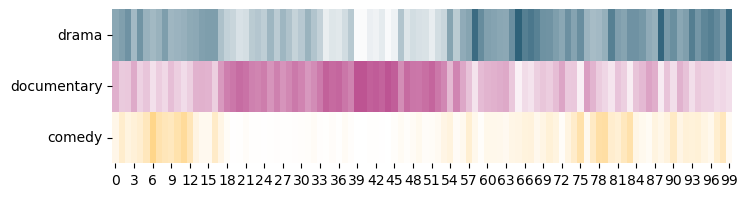

In [34]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot()

sns.heatmap(heatmap_df.T, cmap=colors_all, 
            cbar=None,
            #cbar_kws={'mappable': None, 'cmap':prediction_colors}, 
            ax=ax)

plt.show()
plt.close()

### 5.3 Hidden State Distances

Component (D) gives us a glimpse of which steps in the sequence have the most impact on the model's predictions. At each step, it calculates the distance between the model's hidden state at that step and the hidden state at the previous step. The idea is that input words that move the hidden state by a greater distance are more impactful. It displays the information in a bar chart, with normalized distance represented by bar height and predictions (with confidence) represented by bar color.

In [35]:
def hidden_distances(hiddens):
    hiddens_lag = np.concatenate([np.zeros((1, hidden_size)), hiddens[:-1]])
    distances = np.sqrt(np.sum(np.square(hiddens - hiddens_lag), axis=1))
    return distances
    
def get_max_hidden_distance(all_hidden_states): # all_hidden_states is an iterable of tensors
    return max(hidden_distances(hiddens.detach().numpy()).max() for hiddens in all_hidden_states)  

def predictions_to_colors(predictions, confidences, max_alpha=0.75):
    return [tuple(color_float_map[pred] + [confidences[i]*max_alpha]) for i, pred in enumerate(predictions)]

In [36]:
with open('data/imdb_hiddens3.pkl', 'rb') as f:
    all_hidden_states = pickle.load(f)

In [37]:
max_hidden_distance = get_max_hidden_distance(all_hidden_states)

In [38]:
distances = hidden_distances(hiddens)
distances_norm = distances/max_hidden_distance

In [39]:
movie_colors = predictions_to_colors(predictions, confidences, max_alpha=1)

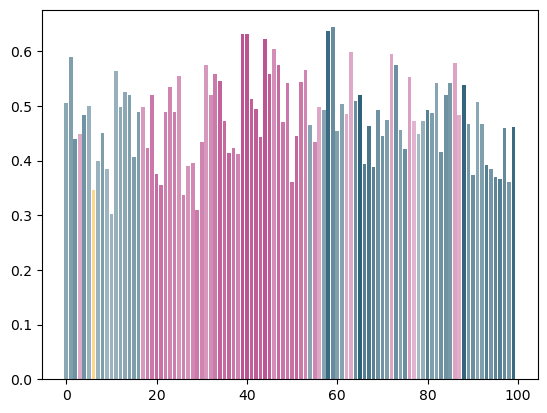

In [40]:
fig = plt.figure()
ax = fig.add_subplot()

ax.bar(x=[i for i in range(len(outputs))], 
       height=distances_norm,#.detach().numpy(),
       color=movie_colors)

plt.show()
plt.close()

### 5.4 Hidden State Projection

Component (E) serves a dual purpose, giving us general information about the distribution of hidden states and predictions while showing how a given example evolves within that distribution. To create this visualization, we project the hidden states into 2 dimensions and color the points as in component (D) using the model's outputs. The original authors use t-SNE as their projection method, but I use PCA since it's less computationally expensive.

In [41]:
with open('data/imdb_outputs3.pkl', 'rb') as f:
    all_outputs = pickle.load(f)

with open('data/imdb_predictions3.pkl', 'rb') as f:
    all_predictions = pickle.load(f)

In [42]:
outputs_tensor = torch.cat(all_outputs)
predictions_tensor = torch.cat(all_predictions)

save_model_states.py fits a PCA model to the training data and pickles everything.

In [43]:
with open('saved_models/pca3.pkl', 'rb') as f:
    ipca = pickle.load(f)
with open('data/imdb_hiddens3_pca.pkl', 'rb') as f:
    hidden_pca = pickle.load(f)

C:\Users\steve\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator IncrementalPCA from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
scatter_colors = []
max_alpha=0.4
for i, output in enumerate(outputs_tensor):
    pred = predictions_tensor[i]
    confidence = output[pred].item()
    scatter_colors.append(tuple(color_float_map[pred.item()] + [confidence*max_alpha]))

In [45]:
hidden_2D_df = pd.DataFrame(hidden_pca[:,0:2], columns=['x','y'])
hidden_2D_df['scatter_color'] = scatter_colors

To improve graphing performance, I display a relatively small random sample of the projected points.

In [46]:
temp = hidden_2D_df.sample(frac=0.001)

In [47]:
hiddens_transformed = ipca.transform(hiddens)

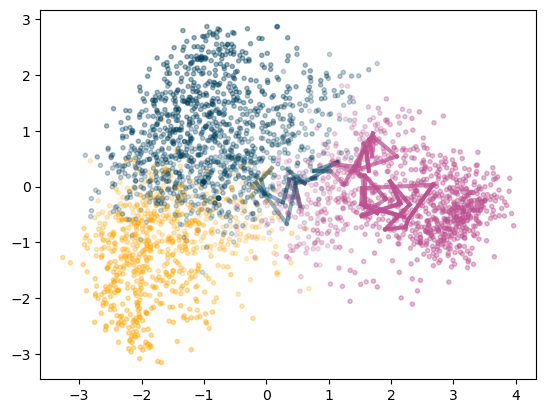

In [48]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(temp['x'], temp['y'], marker='.', c=temp['scatter_color'])
for i, coords in enumerate(hiddens_transformed[:50]):
    ax.plot(hiddens_transformed[i:i+2,0], hiddens_transformed[i:i+2,1], 
            c=movie_colors[i],
            linewidth=3)

plt.show()
plt.close()

The 2D projection does a pretty good job separating the class predictions. The first principal component (X-axis) separates documentaries from dramas and comedies, and the second principal component separates dramas from comedies.

The colored lines show the progression of the example movie description through the hidden state space.